This notebook referred to the tutorial:


*   https://bytepawn.com/training-a-pytorch-wasserstain-mnist-gan-on-google-colab.html
- https://medium.com/dejunhuang/implementing-gan-and-wgan-in-pytorch-551099afde3c
- https://github.com/Zeleni9/pytorch-wgan

In [ ]:
# Connect google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Enter the project's path
import os
path = "/content/drive/MyDrive/portrait"
os.chdir(path)
!ls

dddd


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# import os
# import numpy as np
import math
import sys
from time import time
# import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
# from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
# import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class Opt(object):
    dim = 10
    n_epochs = 2
    batch_size = dim*dim
    lr = 0.00005
    n_gpu = 1
    latent_dim = 100
    img_size = 256
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 400

opt = Opt()  

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

In [ ]:
# Root directory for dataset
dataroot = "dddd"

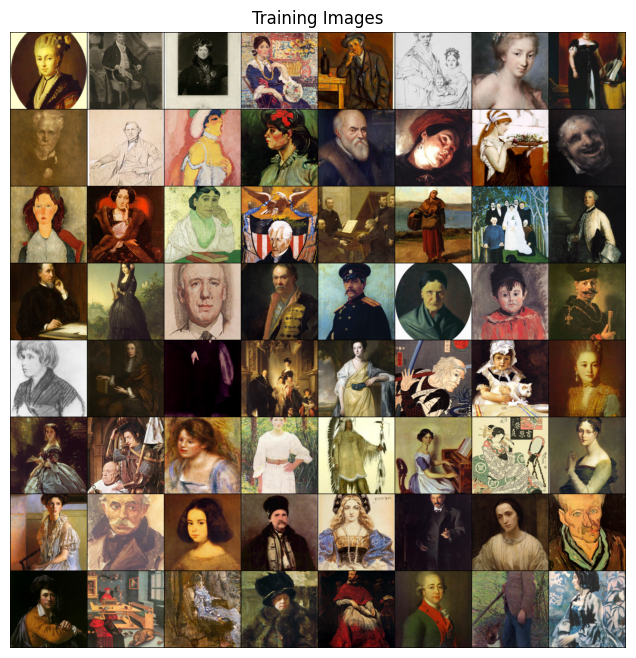

In [ ]:
# Pytorch加载图像数据集需要两步，首先需要使用**torchvision.datasets.ImageFolder()读取图像，然后再使用torch.utils.data.DataLoader()**加载数据集。
# 创建torch能够识别的数据集类型：


# ImageFolder假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名           
dataset = dset.ImageFolder(root=dataroot,                    #在root指定的路径下寻找图片
                           transform=transforms.Compose([ 
                               transforms.Resize(256),      #按照比例把图像最小的一个边长放缩到256，另一边按照相同比例放缩。
                               transforms.CenterCrop(256),  #中心裁剪 
                               transforms.ToTensor(),       #转为tensor，并归一化至[0-1]
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]) )


# Create dataloader：把数据集放在dataloader中可生成一个迭代器，从而方便进行批处理
dataloader = torch.utils.data.DataLoader(dataset,           #torch TensorDataset format 
                                         batch_size=10*10,  #mini batch size
                                         shuffle=True,      #是否打乱数据
                                         num_workers=5)     #多线程读数据

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and opt.n_gpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))) #将若干幅图像拼成一幅

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 256 * 256 * 3),  # Update output size to 28x28x3
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], 3, 256, 256)  # Update to 3-channel image
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(256 * 256 * 3, 512),  # Update input size to 28x28x3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# # Configure data loader
# os.makedirs("../../data/mnist", exist_ok=True)
# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         "../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
#     ),
#     batch_size=opt.batch_size,
#     shuffle=True,
# )

# Optimizers
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


# Training

In [ ]:
%%time 

batches_done = 0
saved_imgs = []
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        discriminator_loss = torch.mean(discriminator(fake_imgs)) - torch.mean(discriminator(real_imgs))
        discriminator_loss.backward()
        discriminator_optimizer.step()
        # clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)
        # train the generator every n_critic iterations
        if i % opt.n_critic == 0:
            # train Generator
            generator_optimizer.zero_grad()
            # generate a batch of fake images
            critics_fake_imgs = generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(discriminator(critics_fake_imgs))
            generator_loss.backward()
            generator_optimizer.step()
        batches_done += 1
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
    #.numpy() converts a tensor object into an numpy.ndarray object. 
    #transpose() (1,2,0)是第1个维度变3，第2个维度变第1，第三个维度变第2
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)

Epoch 0 training... done, took 115.3 seconds.
Epoch 1 training... done, took 120.1 seconds.
CPU times: user 9.22 s, sys: 6.14 s, total: 15.4 s
Wall time: 3min 55s


In [ ]:
print(discriminator_loss)
print(generator_loss)

tensor(-47.3526, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-46.5242, device='cuda:0', grad_fn=<NegBackward0>)


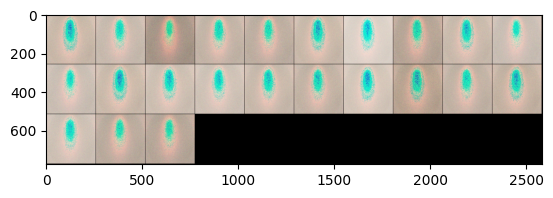

In [ ]:
plt.imshow(img)

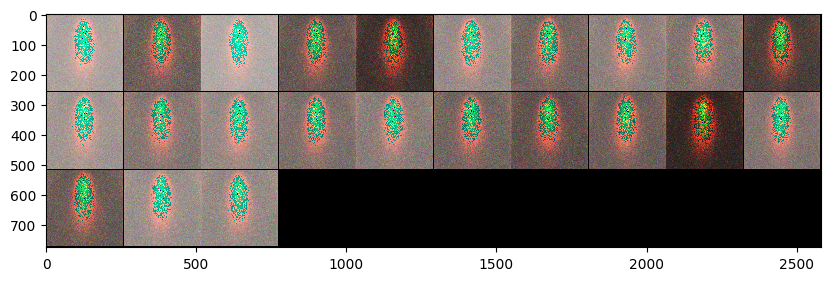

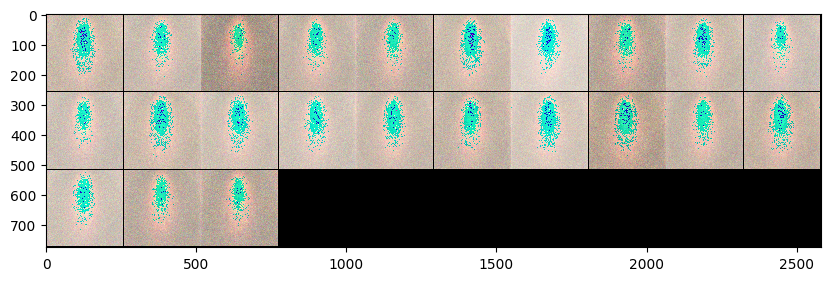

In [ ]:
img_indexes = [0, 1]

for i in img_indexes:
    plt.figure(figsize = (10, 10))
    plt.imshow(saved_imgs[i], interpolation='nearest')